In [27]:
import sys
import os
import shutil

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


In [2]:
from pathlib import Path
import sys

from lib.Utilities import *
import torch

import h5py
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d

from PIL import Image

from tqdm.notebook import tqdm

In [29]:
# First purging all the existing data folders so we start from scratch
# Define source and destination directories
folders = ['../data/train/artifact', '../data/train/non-artifact', '../data/val/artifact', '../data/val/non-artifact', '../data/test/artifact', '../data/test/non-artifact']

for folder in folders:
	if os.path.exists(folder):
		shutil.rmtree(folder)
	os.makedirs(folder)


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_abp(abp_data):

   # Plotting the two 1D arrays with different colors
	plt.figure(figsize=(10, 6))
	plt.plot(abp_data, label='ABP Data')
	plt.grid(True)
	plt.show()

def display_image(image):
	plt.imshow(image, cmap='viridis', aspect='auto')
	plt.title('1D Signal Represented in 64x64 Image')
	plt.show()

In [31]:
hdf5_file_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/Patient_2021-12-21_04_16.h5'
annotation_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/20240207-annotations-export-workspace=precicecap-patient=7-annotation_group=90.csv'
annotation_metadata = {
	'modality':'ART'
	,'location':'na'
	,'scale_wrt_hd5':1e3
}
# segment_length_sec = 3

data_group_name='Waveforms/ART_na'
timestamp_group_name='Waveforms/ART_na_Timestamps'
sampling_frequency=125

df_annotation = pd.read_csv(annotation_path)
df_annotation_filtered = df_annotation[(df_annotation['modality']==annotation_metadata['modality']) & (df_annotation['location']==annotation_metadata['location'])]

artifacts = df_annotation_filtered[["start_time","end_time"]].to_numpy() * int(annotation_metadata['scale_wrt_hd5'])

In [32]:
with h5py.File(hdf5_file_path, 'r') as file:
	dataset = file[data_group_name]
	timestamp = file[timestamp_group_name]

	data, timestamp = dataset[:], timestamp[:]

In [33]:
artifact_raw = []
for art in artifacts:
	start_idx = np.searchsorted(timestamp, art[0], side='left')
	end_idx = np.searchsorted(timestamp, art[1], side='left')
	# For 125Hz, the sample_len is 1250 for 10sec sample
	##################################################

	interval_data = data[start_idx:end_idx]
	artifact_raw.append(interval_data)
	

In [34]:
# Now filter the artifacts whose more than 50% data is less than zero
# Calculate the percentage < 0 in the array
artifact_raw_clean = []
for arr in artifact_raw:
	if arr.size==0:
		continue
	percentage = (np.sum(arr < 0) / arr.size) * 100

	# Check if the percentage is greater than 50%
	if percentage >= 50:
		count_less_than_zero = np.sum(arr < 0)
		print(f"Out of {arr.shape}, {count_less_than_zero} are negative values")
	else:
		artifact_raw_clean.append(arr)
	

Out of (7496,), 5140 are negative values
Out of (915701,), 855434 are negative values
Out of (1874,), 1202 are negative values
Out of (4997,), 3261 are negative values


#### Now get the pulses, interpolate to 64 points, normalize to 0-1 and convert to image

In [35]:
def get_pulses(signal, sigma=2):
	filtered_signal = gaussian_filter1d(signal, sigma=sigma)

	troughs, _ = scipy.signal.find_peaks(-filtered_signal)
	pulses = []
	for i in range(len(troughs)-1):
		s=signal[troughs[i]:troughs[i+1]]
		
		if len(s)>0:
			pulses.append(s)
	
	return pulses
	

In [36]:
def interpolate_and_normalize(signal):
	# Original indices
	x_original = np.arange(len(signal))

	# New indices for the desired length of 64
	x_new = np.linspace(0, len(signal) - 1, 64)

	# Perform cubic spline interpolation
	cs = scipy.interpolate.CubicSpline(x_original, signal)
	interpolated_array = cs(x_new)

	# Normalize the interpolated array to have values between 0 and 1
	normalized_array = (interpolated_array - interpolated_array.min()) / (interpolated_array.max() - interpolated_array.min())
	
	# Convert the nan elements to zero
	normalized_array[np.isnan(normalized_array)] = 0

	return normalized_array

In [37]:
def convert_1d_into_image(signal):
	image=np.zeros((64,64))
	for x,y in enumerate(signal):
		image[x][int(y*63)]=1
	
	image = np.rot90(image, k=1)

	return image
	

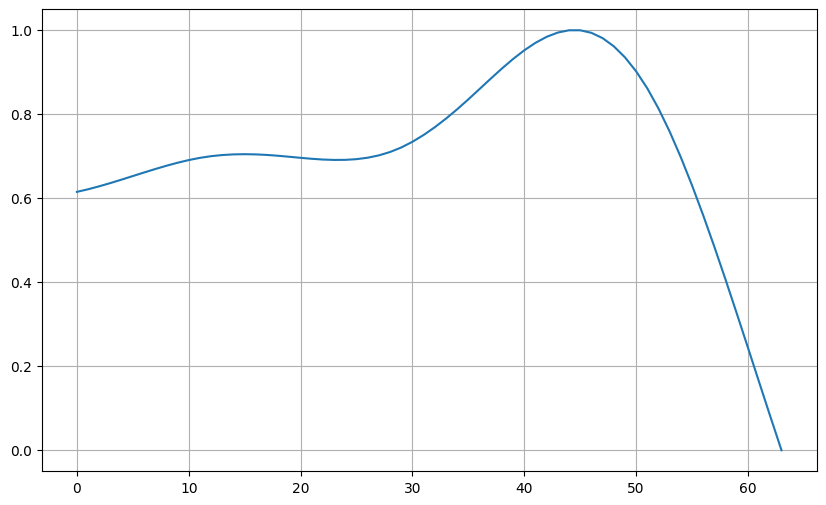

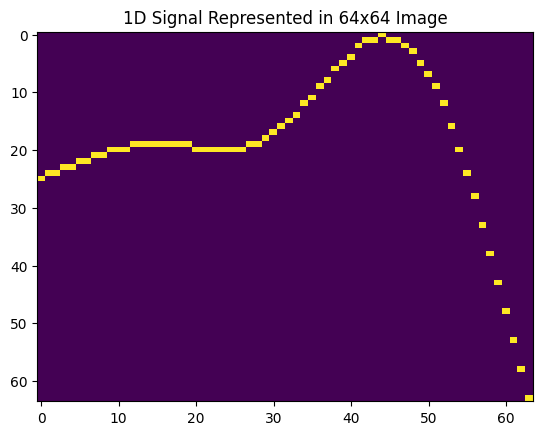

In [38]:
signal=artifact_raw_clean[0]
pulses = get_pulses(signal)

p = pulses[0]
d = interpolate_and_normalize(pulses[1])
image = convert_1d_into_image(d)

plot_abp(d)
display_image(image)

In [39]:
def create_images_from_signal(raw_clean_signal):
	count_pulses=0
	for signal in tqdm(raw_clean_signal):
		pulses = get_pulses(signal, sigma=3)

		for idx, p in enumerate(pulses):
			
			d = interpolate_and_normalize(p)
			image = convert_1d_into_image(d)
			
			image_to_save = Image.fromarray(image.astype('uint8')*255, 'L')

			image_to_save.save(f'../data/train/artifact/artifact_{count_pulses}.jpg')
			count_pulses+=1

	print(f'{count_pulses+1} number of pulse images have been created.')		

In [40]:
create_images_from_signal(artifact_raw_clean)

  0%|          | 0/214 [00:00<?, ?it/s]

/tmp/ipykernel_1157340/1468225437.py:13: RuntimeWarning: invalid value encountered in divide
  normalized_array = (interpolated_array - interpolated_array.min()) / (interpolated_array.max() - interpolated_array.min())


15784 number of pulse images have been created.


##### Our target here is to create the same number of non-artifact images. Randomly sample 10 seconds of data, check if there is any overlap with the artifact intervals, if not:
- Gaussian filter 
- Get Pulses
- Interpolate Normalize
- Create Image and store

In [41]:
def has_artifact(candidate_interval, artifacts=artifacts):
	for artifact in artifacts:
		# Calculate the maximum start time and minimum end time between candidate_interval and artifact
		start_max = max(candidate_interval[0], artifact[0])
		end_min = min(candidate_interval[1], artifact[1])
		
		# Check for overlap
		if start_max < end_min:
			# If there is an overlap, return True
			return True
	
	# If no overlap is found with any artifact, return False
	return False


count_non_artifact_data = []

# Generate 5000 unique random values from 0 to 58360000 without replacement
random_values = np.random.choice(range(len(timestamp)), 5000, replace=False)

na_signals = []
for r in random_values:
	start_idx_na, end_idx_na = r, r+1250
	candidate_timestamp = timestamp[start_idx_na:end_idx_na]
	
	if not has_artifact(candidate_timestamp):
		na_signals.append(data[start_idx_na:end_idx_na])

		# TODO: add filter for anomalies just to be safe	

In [42]:
len(na_signals)

4861

In [43]:
def create_images_from_signal_na(raw_clean_signal, total_number=15784):
	count_pulses=0

	for signal in tqdm(raw_clean_signal):
		pulses = get_pulses(signal,sigma=3)

		for p in pulses:
			
			d = interpolate_and_normalize(p)
			image = convert_1d_into_image(d)
			
			image_to_save = Image.fromarray(image.astype('uint8')*255, 'L')

			image_to_save.save(f'../data/train/non-artifact/non_artifact_{count_pulses}.jpg')
			count_pulses+=1

			if count_pulses>=total_number:
				print(f'{count_pulses+1} number of pulse images (non-artifact ridden) have been created.')		
				return 1
	
	print(f'{count_pulses+1} number of pulse images (non-artifact ridden) have been created.')		


In [44]:
create_images_from_signal_na(na_signals)

  0%|          | 0/4861 [00:00<?, ?it/s]

15785 number of pulse images (non-artifact ridden) have been created.


1

### Split the train such that 70% is for training 10% is for validation and 20% is for testing

In [45]:
import os
import shutil
from random import sample

# Define source and destination directories
source_dirs = ['../data/train/artifact', '../data/train/non-artifact']
val_dirs = ['../data/val/artifact', '../data/val/non-artifact']
test_dirs = ['../data/test/artifact', '../data/test/non-artifact']

# Create destination directories if they don't exist
for d in val_dirs + test_dirs:
	os.makedirs(d, exist_ok=True)

# Function to move files
def move_files(src_dir, dest_dir, n):
	files = os.listdir(src_dir)
	# n = int(len(files) * fraction)
	files_to_move = sample(files, n)  # Randomly select files to move

	for f in files_to_move:
		shutil.move(os.path.join(src_dir, f), os.path.join(dest_dir, f))

# Move 10% to val and 20% to test directories

files = os.listdir(source_dirs[0])
test_instance_count = int(0.2*len(files))
val_instance_count = int(0.1*len(files))

for src, val, test in zip(source_dirs, val_dirs, test_dirs):
	move_files(src, val, val_instance_count)  # Move 10% to validation
	move_files(src, test, test_instance_count)  # Move 20% to testing




In [46]:
### Show the total number of files in each directory
for folders in zip(source_dirs, val_dirs, test_dirs):
	for folder in folders:
		print(f'{folder} has {len(os.listdir(folder))} images in it')

../data/train/artifact has 11049 images in it
../data/val/artifact has 1578 images in it
../data/test/artifact has 3156 images in it
../data/train/non-artifact has 11050 images in it
../data/val/non-artifact has 1578 images in it
../data/test/non-artifact has 3156 images in it
